In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Standard library imports
import gdown
import os
import shutil
import zipfile
from concurrent.futures import ThreadPoolExecutor, as_completed

# Numerical and data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image
import cv2

# Machine learning metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)

# PyTorch core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.autograd import Variable

# PyTorch-specific utilities
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

# timm library for pretrained models
import timm

# Transformer utilities
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Progress bar utility
from tqdm import tqdm

In [ ]:
batch_size = 32
# Number of epochs
num_epochs = 200

# Google Drive file ID
file_id = ""
zip_path = "/content/plum_split_dataset.zip"
extract_path = "/content/plum_split_dataset"

# Download dataset
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extraction complete. Files are available at: {extract_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1qaMMOU4t8proK8VHc4cjzb6iDTSdKAKy
From (redirected): https://drive.google.com/uc?id=1qaMMOU4t8proK8VHc4cjzb6iDTSdKAKy&confirm=t&uuid=eca064fd-fbec-4c36-bcc9-769adc31202a
To: /content/plum_split_dataset.zip
100%|██████████| 303M/303M [00:01<00:00, 204MB/s]


Extraction complete. Files are available at: /content/plum_split_dataset


In [ ]:
# Define transformations for resizing, normalization, and data augmentation (for training data)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    #transforms.RandomHorizontalFlip(),  # Data augmentation: random horizontal flip
    #transforms.RandomRotation(20),  # Data augmentation: random rotation
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Define transformations for validation and test data (no augmentation, only resizing and normalization)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Dataset paths
dataset_path = extract_path

# Load datasets
train_data = datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=train_transform)
val_data = datasets.ImageFolder(root=os.path.join(dataset_path, 'val'), transform=val_test_transform)
test_data = datasets.ImageFolder(root=os.path.join(dataset_path, 'test'), transform=val_test_transform)

# Get CPU cores for multi-threaded data loading
num_cpu_cores = os.cpu_count()
num_workers = max(1, num_cpu_cores - 1)  # Use max available cores minus 1

# Enable cuDNN optimizations
torch.backends.cudnn.benchmark = True  # Helps with faster training on GPUs

# Use pin_memory=True for GPU, prefetch_factor for efficient batch preloading

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=True, prefetch_factor=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=True, prefetch_factor=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=True, prefetch_factor=4)

# Print dataset sizes
print(f"Training dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print(f"Test dataset size: {len(test_data)}")

Training dataset size: 3153
Validation dataset size: 457
Test dataset size: 897


In [ ]:
# Iterate over one batch to check the data
images, labels = next(iter(train_loader))

print(f"Batch size: {images.size(0)}")
print(f"Image dimensions: {images.size(1)} x {images.size(2)} x {images.size(3)}")

Batch size: 32
Image dimensions: 3 x 224 x 224


In [ ]:
import os

dataset_path = "/content/plum_split_dataset"

# Get subfolders and their file counts
subfolders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]

for subfolder in subfolders:
    num_files = sum([len(files) for _, _, files in os.walk(subfolder)])
    print(f"Subfolder: {subfolder}, Number of files: {num_files}")


Subfolder: /content/plum_split_dataset/val, Number of files: 457
Subfolder: /content/plum_split_dataset/train, Number of files: 3153
Subfolder: /content/plum_split_dataset/test, Number of files: 897


## Train the model

In [ ]:
def select_model():
    models = [
        'squeezenet',
        'shufflenet',
        'efficientnet_b0',
        'mobilenet_v2',
        'mobilenet_v3_small',
        'resnet18',
        'xception',
        'ga_ghostnet'
    ]

    print("Select a model:")
    for idx, model_name in enumerate(models, start=1):
        print(f"{idx}. {model_name}")

    try:
        choice = int(input("Enter the number of the model you want to select: ")) - 1

        if 0 <= choice < len(models):
            return models[choice]
        else:
            print("Invalid choice. Defaulting to 'resnet18'.")
            return 'resnet18'
    except ValueError:
        print("Invalid input. Defaulting to 'resnet18'.")
        return 'resnet18'

model_name = select_model()
print(f"Selected model: {model_name}")

Select a model:
1. squeezenet
2. shufflenet
3. efficientnet_b0
4. mobilenet_v2
5. mobilenet_v3_small
6. resnet18
7. xception
8. ga_ghostnet
Enter the number of the model you want to select: 8
Selected model: ga_ghostnet


In [ ]:
# Efficient Channel Attention (ECA)
class ECA(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y

# Convolutional Block Attention Module (CBAM)
class CBAM(nn.Module):
    def __init__(self, channel, reduction=16, spatial_kernel=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channel, channel // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=spatial_kernel, stride=1, padding=spatial_kernel // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_ca = self.channel_attention(x) * x
        max_pool = torch.max(x_ca, dim=1, keepdim=True)[0]
        avg_pool = torch.mean(x_ca, dim=1, keepdim=True)
        spatial_attn = torch.cat([max_pool, avg_pool], dim=1)
        spatial_attn = self.spatial_attention(spatial_attn)
        return x_ca * spatial_attn

# Ghost Module
class GhostModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, ratio=2, dw_kernel_size=3):
        super(GhostModule, self).__init__()
        self.primary_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // ratio, kernel_size, stride=1, padding=kernel_size // 2, bias=False),
            nn.BatchNorm2d(out_channels // ratio),
            nn.ReLU(inplace=True)
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(out_channels // ratio, out_channels // ratio, dw_kernel_size, stride=1, padding=dw_kernel_size // 2, groups=out_channels // ratio, bias=False),
            nn.BatchNorm2d(out_channels // ratio),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        primary_output = self.primary_conv(x)
        cheap_output = self.cheap_operation(primary_output)
        return torch.cat([primary_output, cheap_output], dim=1)

# GA-GhostNet Block
class GAGhostNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, attention=None):
        super(GAGhostNetBlock, self).__init__()
        self.stride = stride

        self.ghost1 = GhostModule(in_channels, out_channels, kernel_size=kernel_size)

        if stride > 1:
            self.depthwise_conv = nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2, groups=out_channels, bias=False)
            self.bn = nn.BatchNorm2d(out_channels)

        self.ghost2 = GhostModule(out_channels, out_channels, kernel_size=kernel_size)

        if attention == "CBAM":
            self.attention = CBAM(out_channels)
        elif attention == "ECA":
            self.attention = ECA(out_channels)
        else:
            self.attention = None

    def forward(self, x):
        out = self.ghost1(x)
        if self.stride > 1:
            out = self.depthwise_conv(out)
            out = self.bn(out)
        out = self.ghost2(out)
        if self.attention:
            out = self.attention(out)
        return out

# GA-GhostNet
class GAGhostNet(nn.Module):
    def __init__(self, num_classes=1000, attention="CBAM"):
        super(GAGhostNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = GAGhostNetBlock(16, 32, kernel_size=3, stride=1, attention=attention)
        self.layer2 = GAGhostNetBlock(32, 64, kernel_size=3, stride=2, attention=attention)
        self.layer3 = GAGhostNetBlock(64, 128, kernel_size=3, stride=2, attention=attention)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
if model_name == 'resnet18':
    # Load ResNet18 model with pre-trained weights
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(train_data.classes))

elif model_name == 'mobilenet_v2':
    # Load MobileNetV2 model with pre-trained weights
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, len(train_data.classes))

elif model_name == 'mobilenet_v3_small':
    # Load MobileNetV3 Small model with pre-trained weights
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    num_ftrs = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_ftrs, len(train_data.classes))

elif model_name == 'squeezenet':
    # Load SqueezeNet model with pre-trained weights
    model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
    model.classifier[1] = nn.Conv2d(512, len(train_data.classes), kernel_size=(1, 1), stride=(1, 1))
    model.num_classes = len(train_data.classes)

elif model_name == 'shufflenet':
    # Load ShuffleNet model with pre-trained weights
    model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(train_data.classes))

elif model_name == 'efficientnet_b0':
    # Load EfficientNet B0 using timm
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(train_data.classes))

elif model_name == 'xception':
    # Load Xception using timm
    model = timm.create_model('xception', pretrained=True, num_classes=len(train_data.classes))

elif model_name == 'ga_ghostnet':
    # Load GA-GhostNet with user-specified attention type
    num_classes = len(train_data.classes)

    # Ask the user to input the attention type interactively
    print("Choose the attention type for GA-GhostNet: 'CBAM', 'ECA', or 'None'")
    attention_type = input("Enter the attention type (default is 'CBAM'): ").strip().upper()

    # Validate the user input
    if attention_type not in ['CBAM', 'ECA', 'NONE']:
        print("Invalid input. Defaulting to 'CBAM'.")
        attention_type = 'CBAM'

    # Convert 'None' input to actual None
    attention_type = None if attention_type == 'NONE' else attention_type

    # Update model name to reflect the chosen attention type
    model_name = f"ga_ghostnet_{attention_type.lower()}" if attention_type else "ga_ghostnet_none"

    # Initialize the GA-GhostNet model with the specified attention type
    model = GAGhostNet(num_classes=num_classes, attention=attention_type)

    print(f"Selected model: {model_name}")

else:
    raise ValueError(f"Model name {model_name} is not recognized. Please choose one of the following: "
                     "'resnet18', 'mobilenet_v2', 'mobilenet_v3_small', 'squeezenet', 'shufflenet', "
                     "'efficientnet_b0', 'xception', or 'ga_ghostnet'.")


Choose the attention type for GA-GhostNet: 'CBAM', 'ECA', or 'None'
Enter the attention type (default is 'CBAM'): ECA
Selected model: ga_ghostnet_eca


In [ ]:
base_folder = '/content/drive/MyDrive/plum_result_new'
save_folder = os.path.join(base_folder, model_name)
os.makedirs(save_folder, exist_ok=True)

In [ ]:
print(model)

GAGhostNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): GAGhostNetBlock(
    (ghost1): GhostModule(
      (primary_conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (cheap_operation): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (ghost2): GhostModule(
      (primary_conv): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05

In [ ]:
# Initialize model and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Unfreeze all layers for training
for param in model.parameters():
    param.requires_grad = True

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Lists to store the training and validation loss values for each epoch
train_losses = []
val_losses = []

# Initialize variables to track the best validation loss, epoch, and corresponding train loss
best_val_loss = float('inf')
best_epoch = 0
best_train_loss = 0.0
epochs_without_improvement = 0
lr_patience = 10  # Number of epochs without improvement to reduce lr
early_stopping_patience = 25  # Number of epochs without improvement to stop training

# Define the path to save validation loss and epoch number
loss_info_path = os.path.join(save_folder, f'{model_name}_best_val_loss_info.txt')

# Set the minimum learning rate to a small value (e.g., 1e-6)
min_lr = 1e-6

# Learning rate scheduler to reduce lr after no improvement for `lr_patience` epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=lr_patience, factor=0.1, min_lr=min_lr)

# Initialize a variable to store the previous learning rate
previous_lr = scheduler.optimizer.param_groups[0]['lr']

# Variable to store the last epoch
last_epoch = 0

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Set the model to training mode
    model.train()

    # Initialize variables to accumulate loss for each epoch
    running_loss = 0.0

    # Training phase with tqdm
    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Compute average training loss for the epoch
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase without tqdm
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        for val_inputs, val_labels in val_loader:
            # Move data to GPU if available
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            # Forward pass
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            # Accumulate validation loss
            val_running_loss += val_loss.item()

    # Compute average validation loss for the epoch
    epoch_val_loss = val_running_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch + 1  # Save the epoch number (1-indexed)
        best_train_loss = epoch_train_loss  # Save the training loss for this best epoch
        epochs_without_improvement = 0  # Reset counter

        # Update the model save path with a simplified name
        model_save_path = os.path.join(save_folder, f'{model_name}_best_model.pth')

        torch.save(model, model_save_path)
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        print(f"Model (architecture + weights) saved at {model_save_path}")

    else:
        epochs_without_improvement += 1  # Increment counter if no improvement

    # Print the losses for this epoch
    print(f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Adjust learning rate if no improvement for `lr_patience` epochs
    scheduler.step(epoch_val_loss)

    # Check for learning rate change and print only if it has changed
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    if current_lr != previous_lr:
        print(f"Learning Rate changed to: {current_lr:.6f}")
        previous_lr = current_lr  # Update the previous learning rate

    # Early stopping condition
    if epochs_without_improvement >= early_stopping_patience:
        print(f"Stopping early at epoch {epoch+1} due to no improvement in validation loss for {early_stopping_patience} epochs.")
        last_epoch = epoch + 1  # Save the last epoch where training stopped
        break

# Save the best validation loss, training loss of the best epoch, epoch number, and last epoch to a text file
with open(loss_info_path, 'w') as f:
    f.write(f"Best Validation Loss: {best_val_loss:.4f}\n")
    f.write(f"Best Epoch: {best_epoch}\n")
    f.write(f"Training Loss of Best Epoch: {best_train_loss:.4f}\n")
    f.write(f"Last Epoch: {last_epoch}\n")

print("Training complete.")

Epoch 1/200


Best model saved with validation loss: 1.2616
Model (architecture + weights) saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Train Loss: 1.4464, Val Loss: 1.2616
Epoch 2/200


Train Loss: 1.2549, Val Loss: 1.3054
Epoch 3/200


Best model saved with validation loss: 1.0865
Model (architecture + weights) saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Train Loss: 1.1828, Val Loss: 1.0865
Epoch 4/200


Train Loss: 1.1333, Val Loss: 1.1027
Epoch 5/200


Best model saved with validation loss: 1.0770
Model (architecture + weights) saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Train Loss: 1.0844, Val Loss: 1.0770
Epoch 6/200


Best model saved with validation loss: 1.0539
Model (architecture + weights) saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Train Loss: 1.0394, Val Loss: 1.0539
Epoch 7/200


Best model saved with validation loss: 1.0155
Model (architecture + weights) saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Train Loss: 0.9985, Val Loss: 1.0155
Epoch 8/200


Best model saved with validation loss: 0.9369
Model (architecture + weights) saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Train Loss: 0.9520, Val Loss: 0.9369
Epoch 9/200


Best model saved with validation loss: 0.9222
Model (architecture + weights) saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Train Loss: 0.9204, Val Loss: 0.9222
Epoch 10/200


Train Loss: 0.8794, Val Loss: 0.9942
Epoch 11/200


Train Loss: 0.8365, Val Loss: 0.9363
Epoch 12/200


Train Loss: 0.8060, Val Loss: 1.1059
Epoch 13/200


Best model saved with validation loss: 0.8758
Model (architecture + weights) saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Train Loss: 0.8027, Val Loss: 0.8758
Epoch 14/200


Best model saved with validation loss: 0.8737
Model (architecture + weights) saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Train Loss: 0.7149, Val Loss: 0.8737
Epoch 15/200


Train Loss: 0.7186, Val Loss: 0.9128
Epoch 16/200


Best model saved with validation loss: 0.8512
Model (architecture + weights) saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Train Loss: 0.6439, Val Loss: 0.8512
Epoch 17/200


Train Loss: 0.6326, Val Loss: 0.9484
Epoch 18/200


Train Loss: 0.5792, Val Loss: 0.9017
Epoch 19/200


Train Loss: 0.5664, Val Loss: 0.9295
Epoch 20/200


Train Loss: 0.5184, Val Loss: 0.9597
Epoch 21/200


Train Loss: 0.4895, Val Loss: 1.0087
Epoch 22/200


Train Loss: 0.5061, Val Loss: 0.9335
Epoch 23/200


Train Loss: 0.4758, Val Loss: 1.1660
Epoch 24/200


Train Loss: 0.4488, Val Loss: 1.0948
Epoch 25/200


Train Loss: 0.4210, Val Loss: 1.0027
Epoch 26/200


Train Loss: 0.4120, Val Loss: 1.0162
Epoch 27/200


Train Loss: 0.4002, Val Loss: 1.0866
Learning Rate changed to: 0.000100
Epoch 28/200


Train Loss: 0.3233, Val Loss: 0.9972
Epoch 29/200


Train Loss: 0.2706, Val Loss: 1.0144
Epoch 30/200


Train Loss: 0.2588, Val Loss: 1.0121
Epoch 31/200


Train Loss: 0.2420, Val Loss: 1.0310
Epoch 32/200


Train Loss: 0.2383, Val Loss: 1.0042
Epoch 33/200


Train Loss: 0.2361, Val Loss: 1.0484
Epoch 34/200


Train Loss: 0.2320, Val Loss: 1.0410
Epoch 35/200


Train Loss: 0.2297, Val Loss: 1.0426
Epoch 36/200


Train Loss: 0.2298, Val Loss: 1.0411
Epoch 37/200


Train Loss: 0.2181, Val Loss: 1.0734
Epoch 38/200


Train Loss: 0.2189, Val Loss: 1.0665
Learning Rate changed to: 0.000010
Epoch 39/200


Train Loss: 0.2048, Val Loss: 1.0720
Epoch 40/200


Train Loss: 0.2101, Val Loss: 1.0513
Epoch 41/200


Train Loss: 0.2001, Val Loss: 1.0632
Stopping early at epoch 41 due to no improvement in validation loss for 25 epochs.
Training complete.


In [ ]:
# Calculate model size after training
def calculate_model_size(model):
    temp_model_path = os.path.join(save_folder, f'{model_name}_temp.pth')
    torch.save(model.state_dict(), temp_model_path)
    model_size = os.path.getsize(temp_model_path) / (1024 * 1024)  # Convert bytes to MB
    os.remove(temp_model_path)
    return model_size

# Calculate number of parameters
num_params = sum(p.numel() for p in model.parameters())

# Calculate final model size
final_model_size = calculate_model_size(model)

# Save model size and parameter information
model_info_path = os.path.join(save_folder, f'{model_name}_info.txt')
with open(model_info_path, 'w') as f:
    f.write(f"Final Model Size: {final_model_size:.2f} MB\n")
    f.write(f"Number of Parameters: {num_params:,}\n")

Loss plot saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_graph.png


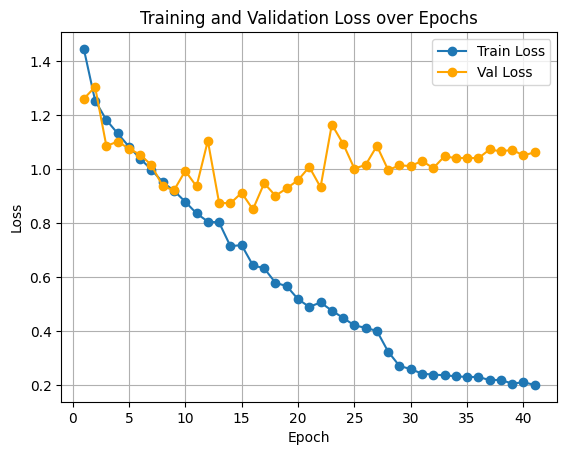

In [ ]:
# Plot the training and validation loss
plt.figure()
plt.plot(range(1, last_epoch+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, last_epoch+1), val_losses, marker='o', label='Val Loss', color='orange')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the plot to Google Drive
train_plots_path = os.path.join(save_folder, f'{model_name}_graph.png')
plt.savefig(train_plots_path)
print(f"Loss plot saved at {train_plots_path}")

# Show the plot
plt.show()

## Test the model

In [ ]:
def select_model():
    models = [
        'resnet18',
        'resnet34',
        'resnet50',
        'mobilenet_v2',
        'mobilenet_v3_small',
        'mobilenet_v3_large',
        'vgg16',
        'vgg19',
        'vit_b_16',
        'efficientformer_l1',
        'efficientformerv2_s1',
        'resnet18_TF',
        'ga_ghostnet'  # Added GA-GhostNet model
    ]

    print("Select a model:")
    for idx, model_name in enumerate(models, start=1):
        print(f"{idx}. {model_name}")

    try:
        choice = int(input("Enter the number of the model you want to select: ")) - 1
    except ValueError:
        print("Invalid input. Defaulting to 'resnet18'.")
        return 'resnet18'

    if 0 <= choice < len(models):
        return models[choice]
    else:
        print("Invalid choice. Defaulting to 'resnet18'.")
        return 'resnet18'

load_model_name = select_model()
print(f"Selected model: {load_model_name}")

In [ ]:
base_folder = '/content/drive/MyDrive/results'
load_folder = os.path.join(base_folder, load_model_name)
model_load_path = os.path.join(load_folder, f'{load_model_name}_best_model.pth')
print(f"Checking if the model exists at: {model_load_path}")
if os.path.exists(model_load_path):
  print("Model file exists.")
else:
  print("Model file does not exist.")

In [ ]:
model_load_path = model_save_path

Checking if the model exists at: /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_best_model.pth
Model file exists.


<ipython-input-41-fc44525e2270>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(model_load_path)


Accuracy per class:
bruised: 0.05
cracked: 0.30
rotten: 0.81
spotted: 0.39
unaffected: 0.84
unripe: 0.67
Class-wise accuracy saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_per_class_accuracy.csv
Classification report saved as CSV at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_classification_report.csv
Confusion matrix plot saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_confusion_matrix.png


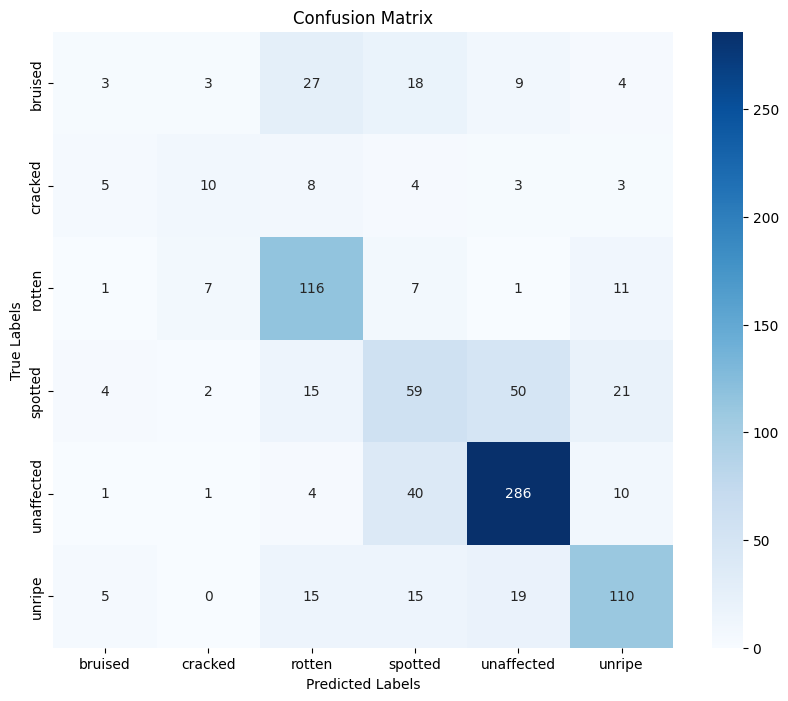

ROC curve plot saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_roc_curve.png


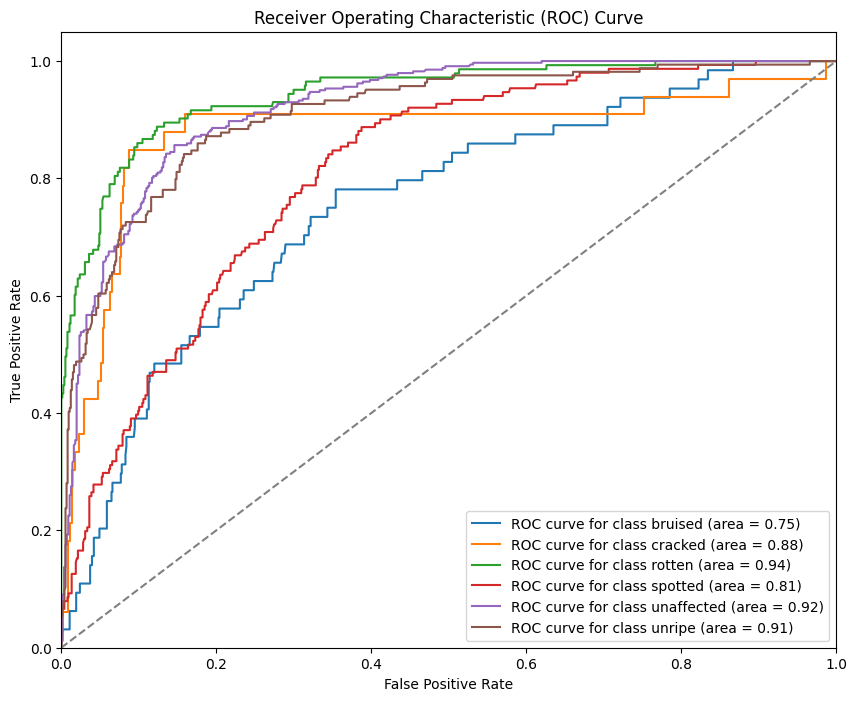

Precision-Recall curve plot saved at /content/drive/MyDrive/plum_result_new/ga_ghostnet_eca/ga_ghostnet_eca_precision_recall_curve.png


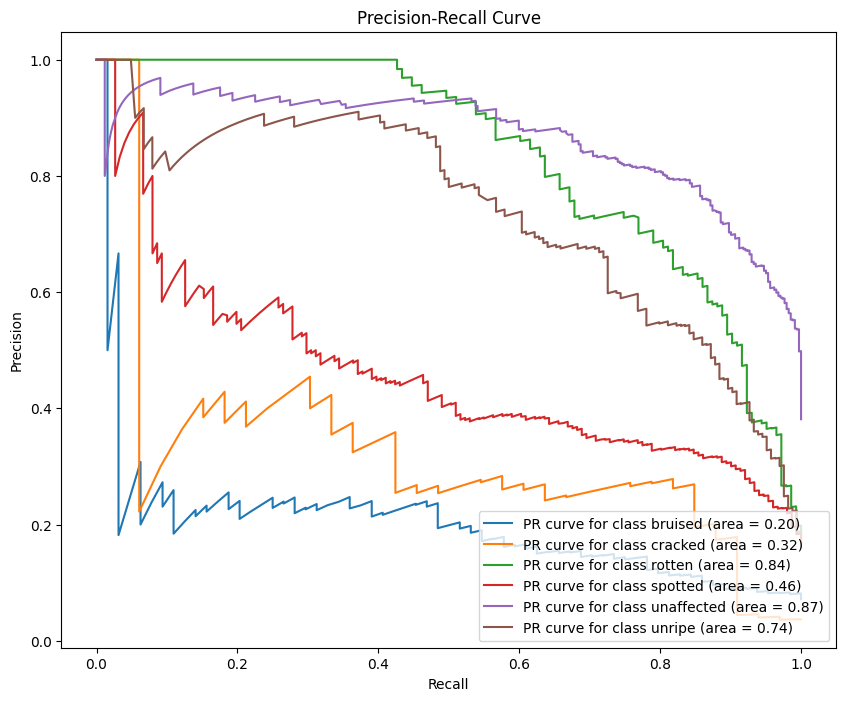

Classification Report:
              precision    recall  f1-score   support

     bruised       0.16      0.05      0.07        64
     cracked       0.43      0.30      0.36        33
      rotten       0.63      0.81      0.71       143
     spotted       0.41      0.39      0.40       151
  unaffected       0.78      0.84      0.81       342
      unripe       0.69      0.67      0.68       164

    accuracy                           0.65       897
   macro avg       0.52      0.51      0.50       897
weighted avg       0.62      0.65      0.63       897



In [ ]:
# Load the saved model directly (without redefining the architecture)
loaded_model = torch.load(model_load_path)


# Define the device before loading the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now move the model to the device
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
print(f"Checking if the model exists at: {model_load_path}")
if os.path.exists(model_load_path):
  print("Model file exists.")
else:
  print("Model file does not exist.")

loaded_model.eval()

# Evaluation loop (unchanged from before)
true_labels = []
pred_labels = []
all_probs = []  # To store predicted probabilities for ROC and AUC

with torch.no_grad():  # Disable gradient tracking for evaluation
    for inputs, labels in test_loader:
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the class with the highest score
        probs = nn.functional.softmax(outputs, dim=1)  # Get predicted probabilities

        # Store the true labels, predicted labels, and predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Generate classification metrics
class_names = train_data.classes  # Class names from training dataset
classification_metrics = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Calculate accuracy for each class using the confusion matrix
class_accuracies = {}
for i, class_name in enumerate(class_names):
    class_accuracies[class_name] = conf_matrix[i, i] / conf_matrix[i].sum()

# Print class-wise accuracy
print("Accuracy per class:")
for class_name, accuracy in class_accuracies.items():
    print(f"{class_name}: {accuracy:.2f}")

# Save class-wise accuracy to a CSV file
class_accuracy_path = os.path.join(save_folder, f'{model_name}_per_class_accuracy.csv')
pd.DataFrame.from_dict(class_accuracies, orient='index', columns=['Accuracy']).to_csv(class_accuracy_path)
print(f"Class-wise accuracy saved at {class_accuracy_path}")

# Save the classification report to a CSV file
classification_df = pd.DataFrame(classification_metrics).transpose()
classification_report_path_csv = os.path.join(save_folder, f'{model_name}_classification_report.csv')
classification_df.to_csv(classification_report_path_csv)
print(f"Classification report saved as CSV at {classification_report_path_csv}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Save the confusion matrix to a PNG file
conf_matrix_plot_path = os.path.join(save_folder, f'{model_name}_confusion_matrix.png')
plt.savefig(conf_matrix_plot_path)
print(f"Confusion matrix plot saved at {conf_matrix_plot_path}")

# Show the confusion matrix
plt.show()

# ROC Curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve([1 if label == i else 0 for label in true_labels], [prob[i] for prob in all_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save ROC Curve plot
roc_curve_path = os.path.join(save_folder, f'{model_name}_roc_curve.png')
plt.savefig(roc_curve_path)
print(f"ROC curve plot saved at {roc_curve_path}")

# Show the ROC Curve
plt.show()

# Precision-Recall Curve for each class
precision = {}
recall = {}
prc_auc = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve([1 if label == i else 0 for label in true_labels], [prob[i] for prob in all_probs])
    prc_auc[i] = auc(recall[i], precision[i])

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'PR curve for class {class_names[i]} (area = {prc_auc[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")

# Save Precision-Recall Curve plot
pr_curve_path = os.path.join(save_folder, f'{model_name}_precision_recall_curve.png')
plt.savefig(pr_curve_path)
print(f"Precision-Recall curve plot saved at {pr_curve_path}")

# Show the Precision-Recall Curve
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))